In [1]:
## Standard Statsmodels import
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'white'
plt.style.use(['seaborn-talk'])
# pd.set_option('display.max_columns',25)


In [2]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTiitWN7DnJMRDcRvMKL3_xu5Y0fl2u5J2vWOrJOcOy95ZiBulg5HqMftWWeiYFYYNHMuVPDWT_vxVc/pub?output=csv")


In [3]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          5000 non-null   int64  
 1   bedrooms       5000 non-null   int64  
 2   bathrooms      5000 non-null   float64
 3   sqft_living    5000 non-null   int64  
 4   sqft_lot       5000 non-null   int64  
 5   floors         5000 non-null   float64
 6   waterfront     5000 non-null   int64  
 7   sqft_above     5000 non-null   int64  
 8   sqft_basement  5000 non-null   int64  
 9   yr_built       5000 non-null   int64  
 10  yr_renovated   5000 non-null   int64  
 11  zipcode        5000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 468.9 KB


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode
0,1100000,2,1.75,2050,11900,1.0,0,2050,0,1950,0,98004
1,430000,3,1.50,1690,9708,1.5,0,1690,0,1954,0,98006
2,2150000,3,2.75,3470,9610,3.0,1,3470,0,1989,2000,98034
3,336000,4,2.50,2530,8169,2.0,0,2530,0,1993,0,98003
4,649500,3,3.00,3730,383328,1.5,0,2230,1500,1990,0,98038


In [4]:
## Zipcode is really a categorical feature -so converting to string
df['zipcode'] = df['zipcode'].astype(str)


In [5]:
## check for null values 
df.isna().sum().sum()

0

### Checking for Assumptions pre modeling

As a reminder, 2 of the assumptions of linear regression are about the features themselves, which we check for BEFORE we make our model:

     1. Independence of features / little-to-no multicollinearity.

     2. Assumption of Linearity/Linear Relationship of features to the target.

The remaining 2 assumptions are about the model's residuals and therefore can only be checked AFTER we make our model. 

    3. Assumption of Normality/Normally Distributed Residuals 

    4. Assumption of homoscedasticty - or equal variance across residuals.

We will check the first two in this lesson.  We will check the remaining two after we run the model.

In [6]:
## saving list of numeric features to slice for pairplot
num_selector = make_column_selector(dtype_include='number')
cols = num_selector(df.drop(columns='price'))
len(cols)


10

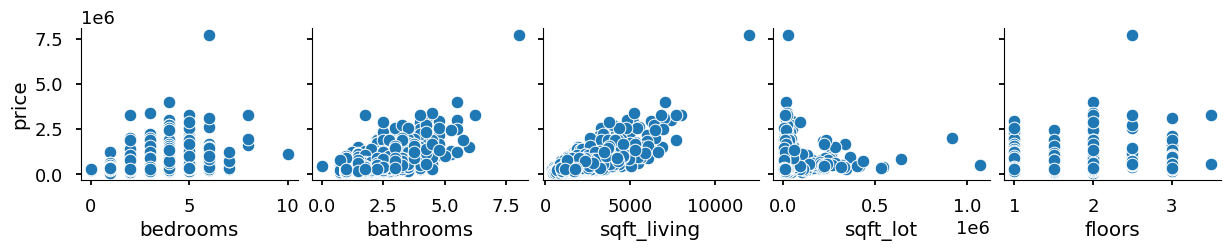

In [7]:
sns.pairplot(df, y_vars='price',x_vars=cols[:5]);


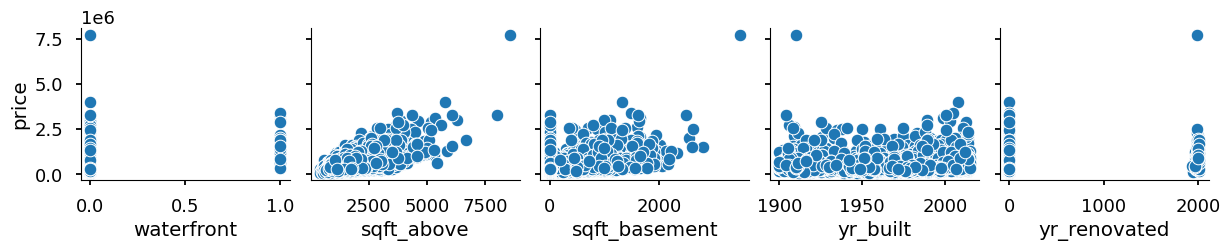

In [9]:
sns.pairplot(df, y_vars='price', x_vars=cols[5:]);

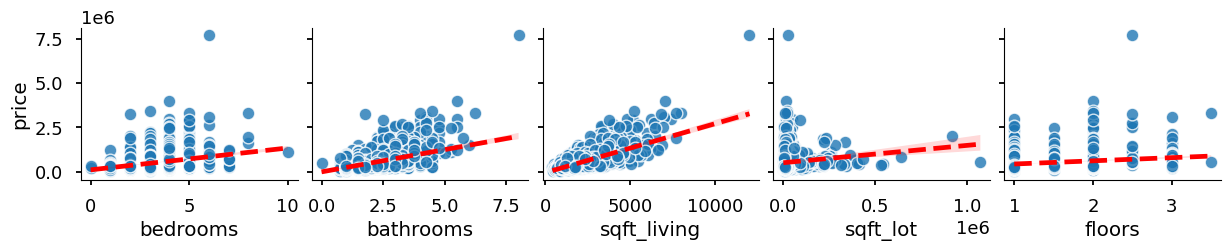

In [10]:
## Making a pairplot with regression lines
sns.pairplot(df, y_vars='price',kind='reg',x_vars=cols[:5],
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));


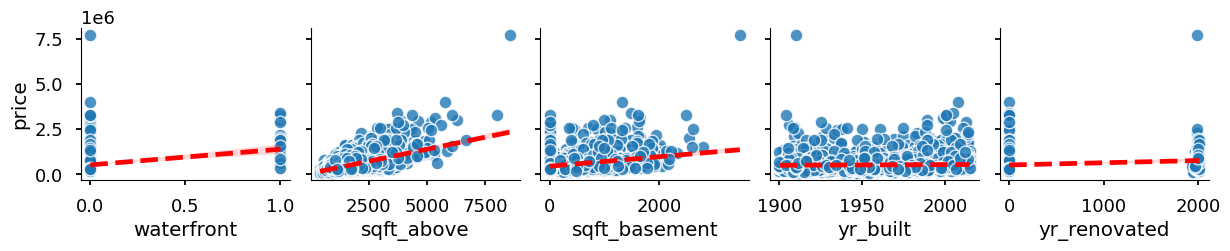

In [11]:
## Making a pairplot with regression lines
sns.pairplot(df, y_vars='price',kind='reg',x_vars=cols[5:],
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));


Looking at the regression plots above, sqft_lot does not seem to have a linear relationship to our target, nor does yr_built.
We will drop them both from the dataset.

In [12]:
## dropping nonlinear features
df = df.drop(columns=['sqft_lot','yr_built'])


In [13]:
## Calc abs values of correlations
corr = df.drop(columns='price').corr().abs()
corr


,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_above,sqft_basement,yr_renovated
bedrooms,1.000000,0.524277,0.586211,0.166878,0.031626,0.480919,0.320743,0.012836
bathrooms,0.524277,1.000000,0.759592,0.498945,0.039355,0.683858,0.304893,0.072898
sqft_living,0.586211,0.759592,1.000000,0.353335,0.064463,0.872318,0.452423,0.073901
floors,0.166878,0.498945,0.353335,1.000000,0.045178,0.527789,0.240627,0.012114
waterfront,0.031626,0.039355,0.064463,0.045178,1.000000,0.053953,0.033323,0.069174
sqft_above,0.480919,0.683858,0.872318,0.527789,0.053953,1.000000,0.041381,0.040899
sqft_basement,0.320743,0.304893,0.452423,0.240627,0.033323,0.041381,1.000000,0.076417
yr_renovated,0.012836,0.072898,0.073901,0.012114,0.069174,0.040899,0.076417,1.000000


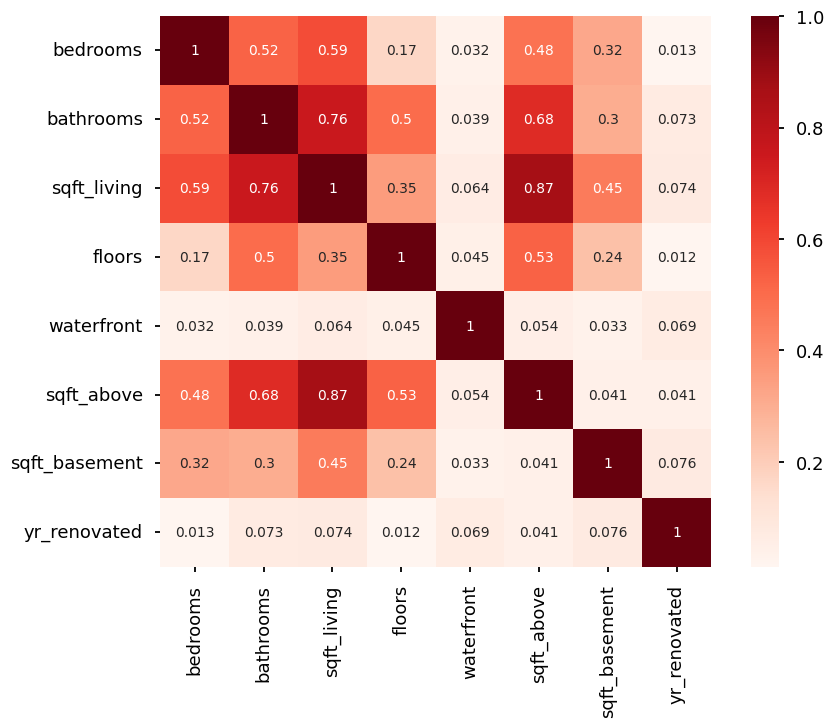

In [14]:
corr = df.drop(columns='price').corr().abs()
sns.heatmap(corr,square=True, cmap='Reds', annot=True);


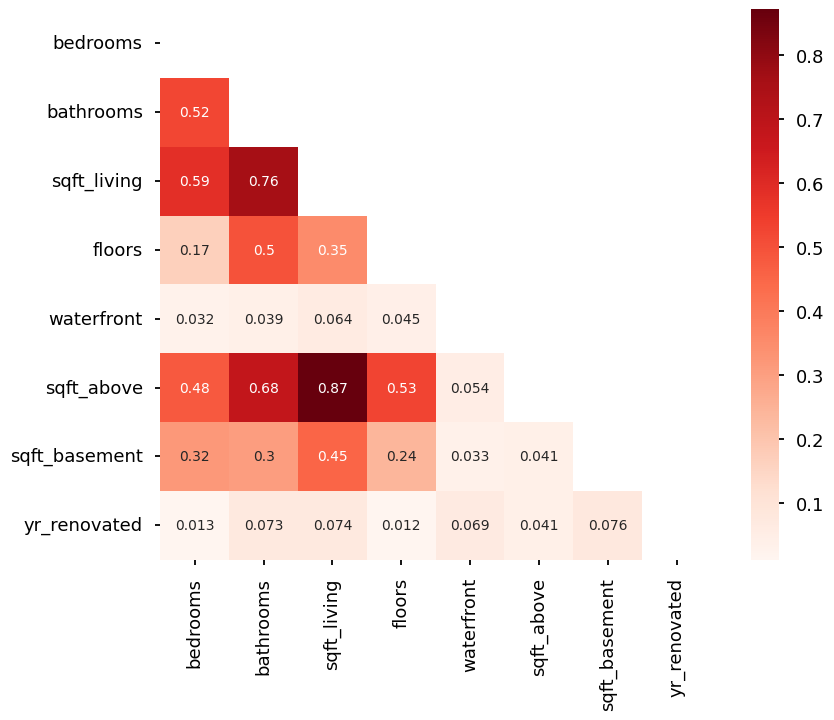

In [15]:
## Calculating the mask to hide the upper-right of the triangle
corr = df.drop(columns='price').corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);



Identifying Correlated Features to Drop
Looking at the correlation heatmap above, we can identify one correlation that is greater than 0.8. sqft_above vs sqft_living.

We want to identify which feature of the pair to drop.

If one feature has multicollinearity with additional features, that is usually the best one to drop.
In this case, neither feature has multicollinearity with another feature
If we add back price to our correlation heatmap, we can see which of the 2 features has a stronger correlation to our target.

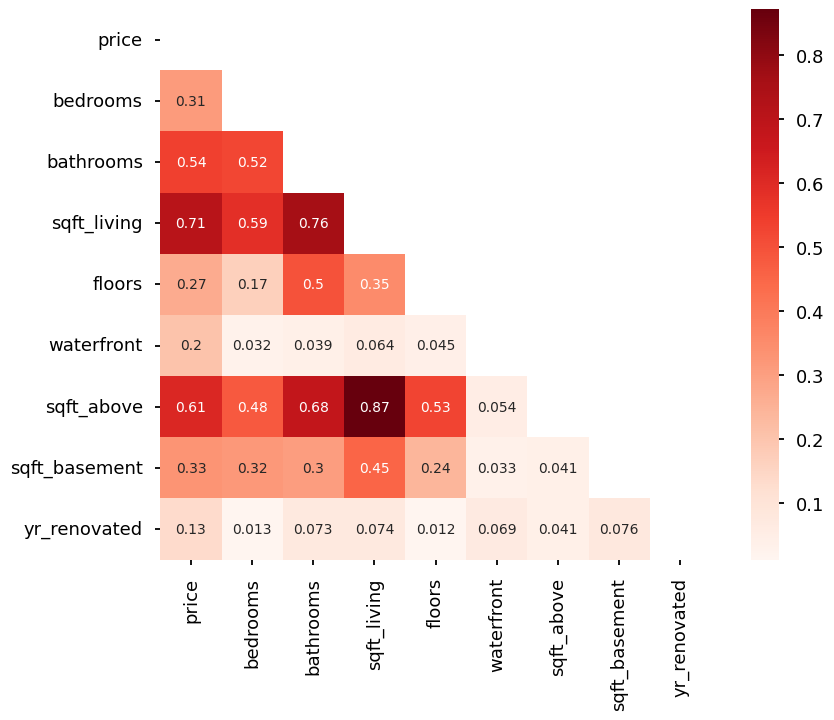

In [16]:
## Adding price back to the correlation heatmap
corr = df.corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);



In [17]:
## Dropping the column showing high corelation
df = df.drop(columns=['sqft_above'])


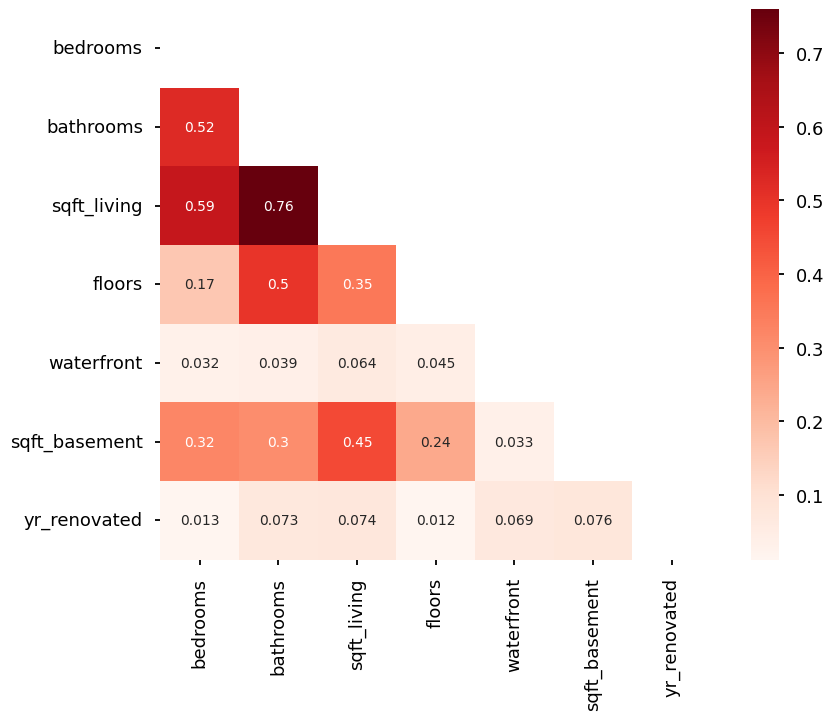

In [18]:
## final check for multicollinearity via correlation
corr = df.drop(columns='price').corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);



### Modeling

In [19]:
## Make x and y variables
y = df['price'].copy()
X = df.drop(columns=['price']).copy()
X_train,X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train.head()


,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,zipcode
1344,3,1.75,1850,1.0,0,0,0,98045
1282,3,2.25,1870,1.0,0,430,0,98011
681,3,1.75,1750,1.5,0,520,0,98117
3851,3,1.00,1170,1.0,0,0,0,98125
3564,2,1.50,901,3.0,0,0,0,98115


In [20]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols



['zipcode']

In [21]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False)
                        )
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
preprocessor = make_column_transformer( (num_pipe, num_cols),
                                       (cat_pipe,cat_cols),
                                       remainder='passthrough')
preprocessor



ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['bedrooms', 'bathrooms', 'sqft_living',
                                  'floors', 'waterfront', 'sqft_basement',
                                  'yr_renovated']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['zipcode'])])

In [22]:
## fit the col transformer to learn feature names 
preprocessor.fit(X_train)
## Now create list of our final features after preprocessing
final_features = []
## adding the numeric features which process first in the Col Trans
final_features.extend(num_cols)
## Now, get OHe feature names
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)
final_features.extend(cat_features)
## Transform X vars and remake as dataframes
X_train_df = pd.DataFrame( preprocessor.transform(X_train), 
                         columns=final_features, 
                         index=X_train.index)
X_test_df = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, 
                         index=X_test.index)
X_test_df.head()



,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,zipcode_98001,zipcode_98002,zipcode_98003,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
2041,3.0,2.50,1520.0,1.0,0.0,440.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2607,3.0,2.25,1490.0,2.0,0.0,450.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4675,4.0,2.00,2060.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4629,3.0,2.50,2130.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4615,3.0,2.50,1980.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
## Adding constants for statsmodels
X_train_df = sm.add_constant(X_train_df, prepend=False)
X_test_df = sm.add_constant(X_test_df, prepend=False)
X_train_df.head(2)



,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,zipcode_98001,zipcode_98002,zipcode_98003,...,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,const
1344,3.0,1.75,1850.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1282,3.0,2.25,1870.0,1.0,0.0,430.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
## make & fit a statmsodels OLS
model = sm.OLS(y_train,X_train_df)
result = model.fit()
print(result.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     170.6
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:41:30   Log-Likelihood:                -50424.
No. Observations:                3750   AIC:                         1.010e+05
Df Residuals:                    3673   BIC:                         1.015e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -4.194e+04   3959.240    -10.592

### Checking the residuals

Finding the Model Residuals

Statsmodels actually stores the residuals inside the model results under the "resid" attribute.

If we are using a scikit-learn linear regression, we can calculate them manually by subtracting our model's predictions from the actual target

In [25]:
# To get our residuals from statsmodels and preview first 5
resid = result.resid
resid.head()


1344    -20242.467226
1282      1016.673278
681     -51423.211967
3851    103498.661493
3564    116338.934543
dtype: float64

- Checking the Assumption of Normality with Q-Q Plots